In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("when_approach").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_11_02")

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-01-22 12:52:45,922 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-01-22 12:52:48,903 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


DataFrame[]

## WHEN Approach

In [2]:
from pyspark.sql.functions import lit,col
import pandas as pd
import numpy as np
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols
from pyspark.ml.feature import StandardScaler
from pyspark.sql.window import Window

In [3]:
def split_train_test(df, split_date):
    split_date = pd.to_datetime(split_date)
    train_df = df.filter(col('date')<split_date)
    test_df = df.filter(col('date')>=split_date)
    return train_df, test_df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')


def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])

    

In [4]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


In [5]:
df = get_df()

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


['ff_assets_gr', 'ff_net_inc_per_emp', 'ff_debt_entrpr_val', 'ff_fcf_yld', 'ff_sga_oth', 'ff_gross_cf_debt', 'ff_dil_adj', 'ff_shs_float', 'ff_xord', 'ff_inc_sund', 'ff_net_inc_basic_beft_xord', 'ff_non_oper_exp', 'ff_cf_ps_gr', 'ff_emp_gr', 'ff_net_inc_bef_xord_gr', 'ff_com_eq_gr', 'ff_mkt_val_gr', 'ff_zscore', 'ff_dfd_tax_assets_lt', 'ff_ut_non_oper_inc_oth', 'ff_mkt_val_public', 'ff_xord_disc', 'ff_bps_gr', 'ff_ut_operation_exp', 'ff_sales_fix_assets', 'CPI', 'ff_bk_non_oper_inc', 'ff_capex_assets']


2024-01-22 12:52:56,790 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+----------+-----------------+-------------------+------------------+----------+----------+-----------------+----------+---------------+-------+-----------+--------------------------+-------------------+------------------+-----------------+----------------------+-----------------+-------------+---------+--------------------+----------------------+-----------------+------------+-----------------+-------------------+-------------------+------------+------------------+-----------------+
| fsym_id|      date|     ff_assets_gr| ff_net_inc_per_emp|ff_debt_entrpr_val|ff_fcf_yld|ff_sga_oth| ff_gross_cf_debt|ff_dil_adj|   ff_shs_float|ff_xord|ff_inc_sund|ff_net_inc_basic_beft_xord|    ff_non_oper_exp|       ff_cf_ps_gr|        ff_emp_gr|ff_net_inc_bef_xord_gr|     ff_com_eq_gr|ff_mkt_val_gr|ff_zscore|ff_dfd_tax_assets_lt|ff_ut_non_oper_inc_oth|ff_mkt_val_public|ff_xord_disc|        ff_bps_gr|ff_ut_operation_exp|ff_sales_fix_assets|         CPI|ff_bk_non_oper_inc|  ff_capex_assets|
+---

114553


114553


Number of rows:  110777


Number of positives:  579


Number of rows after dropping nulls:  110777


Number of positives after dropping nulls:  579


In [6]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt


def boruta_fs(train_df, test_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_test = test_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features


# train_df, test_df = get_df(all_feats=True)
# boruta_features = boruta_fs(train_df, test_df, 'rf')
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [8]:
# train_df = train_df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
#                         'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot' )
# test_df = test_df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
#                         'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot' )



NameError: name 'train_df' is not defined

In [20]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')

In [8]:
feats = df.columns[2:-1]
# write_features_file(feats)
feats

['ff_assets_gr',
 'ff_net_inc_per_emp',
 'ff_debt_entrpr_val',
 'ff_fcf_yld',
 'ff_sga_oth',
 'ff_gross_cf_debt',
 'ff_dil_adj',
 'ff_shs_float',
 'ff_xord',
 'ff_inc_sund',
 'ff_net_inc_basic_beft_xord',
 'ff_non_oper_exp',
 'ff_cf_ps_gr',
 'ff_emp_gr',
 'ff_net_inc_bef_xord_gr',
 'ff_com_eq_gr',
 'ff_mkt_val_gr',
 'ff_zscore',
 'ff_dfd_tax_assets_lt',
 'ff_ut_non_oper_inc_oth',
 'ff_mkt_val_public',
 'ff_xord_disc',
 'ff_bps_gr',
 'ff_ut_operation_exp',
 'ff_sales_fix_assets',
 'CPI',
 'ff_bk_non_oper_inc',
 'ff_capex_assets']

In [1]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline
# from pyspark.ml.linalg import Vectors, VectorUDT
# from pyspark.sql.functions import udf
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
# from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss

def confusion_matrix_pandas(acts, preds):
    cm = confusion_matrix(acts, preds) #correct order
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

        
def feature_importances(model, features):
    feature_importances = model.feature_importances_

    print("Feature Importances:")
    for feature, importance in zip(features, feature_importances):
        print(f"{feature}: {importance}")

    sorted_idx = np.argsort(feature_importances)[::-1]
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.show()

        
def model_testing(df, classifier):
    df = df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'label']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    X_train = df.drop(exclude_columns, axis=1)
    y_train = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag')
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 20, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1)}
        classifier_instance = GradientBoostingClassifier()
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,500,1),
           'max_depth':hp.quniform('max_depth',5,20,1)}
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(scale_pos_weight=estimate, seed=42)
    else:
        raise ValueError("Unsupported classifier")
        
        
        
    tscv = TimeSeriesSplit(n_splits=5)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='f1')
        score = -scores.mean()
        return score
    
    
#     initial_model = classifier_instance
#     initial_model = initial_model.fit(X_train, y_train)
#     initial_preds = pd.DataFrame()
#     print("INITIAL: ")
#     initial_preds['prediction'] = initial_model.predict(X_test)
#     initial_preds['label'] = y_test
#     confusion_matrix_pandas(initial_preds)
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=10, early_stop_fn=no_progress_loss(10))
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    final_recall = None
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        classifier_instance.fit(x_train, Y_train)
        
        preds = classifier_instance.predict(x_test)
        print(f"Classification Report: ")
        print(classification_report(Y_test, preds))
        # cm = confusion_matrix(Y_test, preds, labels=classifier_instance.classes_)
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        final_recall = recall_score(Y_test, preds, pos_label=1)
        # return recall_minority_class
    # return final_recall
        
    if classifier != 'LogisticRegression':
        feature_importances(classifier_instance, X_train.columns.tolist())
        
    return classifier_instance, X_train.columns.tolist(), X_train
#     shapley(classifier_instance, X_train.columns.tolist(), X_train)
        
        

# model_testing(df, 'RandomForest')
# basic_test(train_df, test_df)

In [ ]:
        
def model_testing(df, classifier):
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'label']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    X_train = df.drop(exclude_columns, axis=1)
    y_train = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag')
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 20, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    else:
        raise ValueError("Unsupported classifier")
    tscv = TimeSeriesSplit(n_splits=5)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        else:
            return params
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='f1')
        score = -scores.mean()
        return score
    
    
#     initial_model = classifier_instance
#     initial_model = initial_model.fit(X_train, y_train)
#     initial_preds = pd.DataFrame()
#     print("INITIAL: ")
#     initial_preds['prediction'] = initial_model.predict(X_test)
#     initial_preds['label'] = y_test
#     confusion_matrix_pandas(initial_preds)
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=5)
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    final_recall = None
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        classifier_instance.fit(x_train, Y_train)
        
        preds = classifier_instance.predict(x_test)
        print(f"Classification Report: ")
        print(classification_report(Y_test, preds))
        # cm = confusion_matrix(Y_test, preds, labels=classifier_instance.classes_)
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        final_recall = recall_score(Y_test, preds, pos_label=1)
        # return recall_minority_class
    # return final_recall
        
    if classifier != 'LogisticRegression':
        feature_importances(classifier_instance, X_train.columns.tolist())
        
    return classifier_instance, X_train.columns.tolist(), X_train
#     shapley(classifier_instance, X_train.columns.tolist(), X_train)

In [11]:
def shapley(model, features, X_train, X_test):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.initjs()
    print(shap_values.shape)
    shap.summary_plot(shap_values, X_test)
    # shap.plots.waterfall(shap_values)
    # shap.plots.bar(shap_values)
    # shap.summary_plot(shap_values[0], X_test)
    # shap.summary_plot(shap_values[1], X_test)

# shapley(model, feats, X_train, X_test)

2024-01-22 09:25:53,352 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLike.toSeq(MapLike.scala:75)
	at scala.collection.mutable.MapLike.toSeq$(MapLike.scala:72)
	at scala.collection.mutable.AbstractMap.toSeq(Map.scala:82)
	at org.apache.spark.scheduler.EventLoggingList

Converted to Pandas
             fsym_id  ff_assets_gr  ff_net_inc_per_emp  ff_debt_entrpr_val  \
date                                                                         
2001-01-31  JYS0GH-R     30.130998            0.004602            0.004077   
2001-01-31  FYSXNQ-R     -4.190111            0.005855            0.240762   
2001-01-31  WXCKXC-R    362.295373            0.077503            0.200075   
2001-01-31  GZMRSV-R      0.000000            0.000000            0.000000   
2001-01-31  SL27B1-R     15.255612            0.005969            0.027512   
...              ...           ...                 ...                 ...   
2018-12-31  LLTT6X-R    -10.594743           -0.023289            0.000000   
2018-12-31  LKYRMJ-R     -4.536684           -1.061128            0.592564   
2018-12-31  LKVW3T-R     -4.026814           -0.105273            0.985095   
2018-12-31  LM7NQZ-R     -0.082665            0.055703            0.449658   
2018-12-31  XR7GZL-R      4.200943          

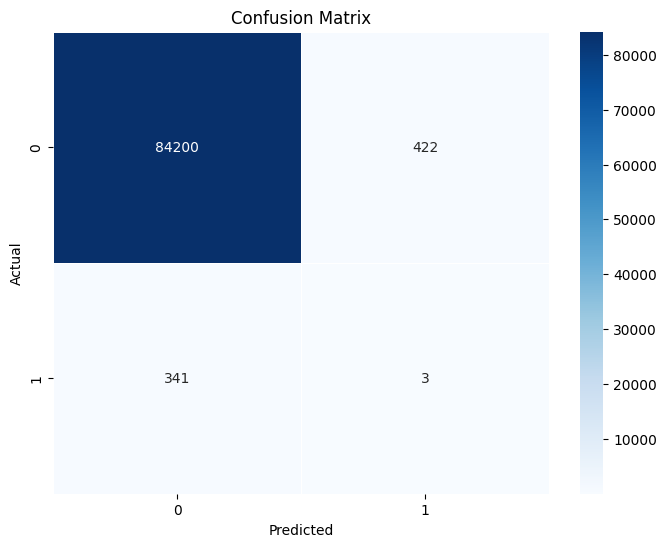

In [49]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    train_df, test_df = split_train_test(df, '2019-01-01')
    features = df.columns[2:-1]
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    print("Converted to Pandas")
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df.set_index('date', inplace=True)
    train_df.sort_index(inplace=True)
    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df.set_index('date', inplace=True)
    test_df.sort_index(inplace=True)
    
    isol_for = IsolationForest(contamination=0.005, random_state=42)
    isol_for.fit(train_df[features])
    train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
    train_df['anomaly'] = isol_for.predict(train_df[features])
    train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)
    print(train_df)
    print(f"Classification Report: ")
    print(classification_report(train_df['label'], train_df['preds']))
    cm = confusion_matrix(train_df['label'], train_df['preds'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    
anomaly_det(df)

In [7]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight



def prepare_seqs(df):
    train_df = df.toPandas()
    # val_split_date = pd.to_datetime('2017-01-01')
    # val_df = train_df[train_df['date'] >= val_split_date]
    # print(len(val_df)/len(train_df))
    # print(len(val_df[val_df['label']==1]))
    # train_df = train_df[train_df['date'] < val_split_date]
    # test_df = test_df.toPandas()
    feature_cols = train_df.columns[2:-1]
    # nn_train_feats = train_df[feature_cols].values
    # nn_train_labels = train_df['label'].values
    # nn_test_feats = test_df[feature_cols].values
    # nn_test_labels = test_df['label'].values
    # nn_val_feats = val_df[feature_cols].values
    # nn_val_labels = val_df['label'].values
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    model = keras.Sequential(
    [
        keras.layers.Dense(16, activation="tanh"),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1, activation = "sigmoid")
    ])
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.005
    )
    
    def plot_model_performance(mdl, loss, metric):
        x = pd.DataFrame(mdl.history).reset_index()
        x = pd.melt(x, id_vars='index')
        x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
        x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
        g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
        g.map(sns.lineplot, 'index','value')
        g.add_legend()
        return g
    
    # space = {
    # 'units1': hp.choice('units1', np.arange(8, 64, dtype=int)),
    # 'units2': hp.choice('units2', np.arange(8, 64, dtype=int)),
    # 'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1))
    # }
#     def objective(params):
#         model = keras.Sequential([
#             keras.layers.Dense(params['units1'], activation="tanh"),
#             keras.layers.Dense(params['units2'], activation="relu"),
#             keras.layers.Dense(1, activation="sigmoid")
#         ])
#         model.compile(optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])

#         # Train and evaluate the model using cross-validation
#         scores = cross_val_score(model, nn_train_feats, nn_train_labels, cv=tscv, scoring='f1')
#         mean_f1 = -np.mean(scores)  # Negate to maximize F1 score
#         return mean_f1
    
#     best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=5)
#     best_units1 = np.arange(8, 64, dtype=int)[best_params['units1']]
#     best_units2 = np.arange(8, 64, dtype=int)[best_params['units2']]
#     best_learning_rate = best_params['learning_rate']
#     final_model = keras.Sequential([
#         keras.layers.Dense(best_units1, activation="tanh"),
#         keras.layers.Dense(best_units2, activation="relu"),
#         keras.layers.Dense(1, activation="sigmoid")])
    model.compile(optimizer=optimizer,
                        loss=loss_fn,
                        metrics=['accuracy'])

    # final_model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weight_dict)
    
    i=1
    for train_idx, val_idx in tscv.split(train_df):
        train_fold = train_df.iloc[train_idx, :]
        val_fold = train_df.iloc[val_idx, :]
        nn_train_feats = train_fold[feature_cols].values
        nn_train_labels = train_fold['label'].values
        nn_val_feats = val_fold[feature_cols].values
        nn_val_labels = val_fold['label'].values
        class_weights = compute_class_weight('balanced', classes=np.unique(nn_train_labels), y=nn_train_labels)
        class_weight_dict = dict(enumerate(class_weights))
        fit_model = model.fit(nn_train_feats, nn_train_labels, epochs=50, batch_size=32, class_weight=class_weight_dict)

        plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

        # Evaluate the model on the test set
        test_loss, test_acc = model.evaluate(nn_val_feats, nn_val_labels)
        print(f'Test accuracy: {test_acc}')

        # Make predictions on new data
        predictions = model.predict(nn_val_feats)
        for i in range(len(predictions)):
            predictions[i] = 1 if predictions[i] >= 0.5 else 0
        print(f"Classification Report for Fold {i}:")
        print(classification_report(nn_val_labels, predictions))
        i+=1
        print(np.sum(nn_val_labels==1))
        print(np.sum(predictions==1))
        cm = confusion_matrix(nn_val_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

# prepare_seqs(df)

2024-01-21 00:44:45.452302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 00:44:45.452341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 00:44:45.453840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 00:44:45.464049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 00:44:46.572114: W tensorflow/compiler/tf2

## Cycling through each year

In [32]:
def cycle(df):
    df = df.withColumn('year', F.year('date'))
    years = df.select("year").distinct().rdd.map(lambda row: row[0]).collect()
    years = sorted(years)
    recalls = []
    for y in years:
        temp_df = df.filter(F.col('year')==y)
        print(f"YEAR: {y}\n")
        recall = model_testing(temp_df, 'LogisticRegression')
        recalls.append(recall)
    plt.plot(recalls)
    plt.show()
    
cycle(df)

+-------+----+------------+------------------+------------------+----------+----------+----------------+----------+------------+-------+-----------+--------------------------+---------------+-----------+---------+----------------------+------------+-------------+---------+--------------------+----------------------+-----------------+------------+---------+-------------------+-------------------+---+------------------+---------------+-----+----+
|fsym_id|date|ff_assets_gr|ff_net_inc_per_emp|ff_debt_entrpr_val|ff_fcf_yld|ff_sga_oth|ff_gross_cf_debt|ff_dil_adj|ff_shs_float|ff_xord|ff_inc_sund|ff_net_inc_basic_beft_xord|ff_non_oper_exp|ff_cf_ps_gr|ff_emp_gr|ff_net_inc_bef_xord_gr|ff_com_eq_gr|ff_mkt_val_gr|ff_zscore|ff_dfd_tax_assets_lt|ff_ut_non_oper_inc_oth|ff_mkt_val_public|ff_xord_disc|ff_bps_gr|ff_ut_operation_exp|ff_sales_fix_assets|CPI|ff_bk_non_oper_inc|ff_capex_assets|label|year|
+-------+----+------------+------------------+------------------+----------+----------+---------------

[2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
YEAR: 2001



Converted to Pandas
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 5/5 [00:01<00:00,  4.39trial/s, best loss: -0.2018120169481122]
Classification Report for Fold 0:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       731
           1       0.11      0.69      0.18        16

    accuracy                           0.87       747
   macro avg       0.55      0.78      0.56       747
weighted avg       0.97      0.87      0.91       747

Classification Report for Fold 0:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       732
           1       0.10      0.73      0.17        15

    accuracy                           0.86       747
   macro avg       0.55      0.80      0.55       747
weighted avg       0.98      0.86      0.91       747

Classification Report for Fold 0:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       737
           1       0.09      0.90      0.17        10


Converted to Pandas
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

 60%|██████    | 3/5 [00:00<00:00,  8.87trial/s, best loss=?]


1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/jupyterhub/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/jupyterhub/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/jupyterhub/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1253, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0



1 fits failed out of a total

100%|██████████| 5/5 [00:00<00:00,  9.89trial/s, best loss=?]



1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/jupyterhub/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/jupyterhub/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/jupyterhub/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1253, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0



1 fits failed out of a total

AllTrialsFailed: 

In [ ]:
# spark.stop()

In [ ]:
# #backup extra code:

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import confusion_matrix
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import cross_validate

# def cross_val(train_df, test_df):
#     feature_cols = train_df.columns[2:-1]
#     print("Features: ",feature_cols)
#     assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
#     lr = LogisticRegression(labelCol='label', featuresCol = 'features')
#     rf = RandomForestClassifier(featuresCol="features", labelCol="label")
#     gb = GBTClassifier(labelCol='label', featuresCol = 'features')
    
#     classifiers = [lr, rf, gb]
    
#     cv_models = []
    
#     evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName='areaUnderROC')
    
#     for classifier in classifiers:
#         print("Starting...")
#         pipeline = Pipeline(stages=[assembler, classifier])
        
#         paramGrid = ParamGridBuilder() \
#         .addGrid(classifier.regParam, [0.01, 0.1]) \
#         .addGrid(classifier.elasticNetParam, [0.0, 0.5]) \
#         .addGrid(classifier.maxIter, [10, 20]) \
#         .build()
        
#         cross_val = CrossValidator(
#             estimator=pipeline,
#             estimatorParamMaps=paramGrid,
#             evaluator=evaluator,
#             numFolds=5
#         )
        
#         cv_model = cross_val.fit(train_df)
#         cv_models.append(cv_model)
#         print("Working")
    
#     for cv_model in cv_models:
#         predictions = cv_model.transform(test_df)
#         auc = evaluator.evaluate(predictions)
#         print(f"Model AUC: {auc}")
        
# def basic_test(train_df, test_df):
#     feature_cols = train_df.columns[2:-1]
#     print("Features: ",feature_cols)
#     assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
#     train_df = assembler.transform(train_df)
#     test_df = assembler.transform(test_df)
#     lr = LogisticRegression(labelCol='label', featuresCol = 'features')
#     rf = RandomForestClassifier(featuresCol="features", labelCol="label")
#     gb = GBTClassifier(labelCol='label', featuresCol = 'features')
    
#     evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName='areaUnderROC')
    
#     lr = lr.fit(train_df)
#     preds_train_df = lr.transform(train_df)
#     preds_test_df = lr.transform(test_df)
    
    
# def cross_val_pandas(train_df, test_df):
#     train_df = train_df.toPandas()
#     test_df = test_df.toPandas()
#     print("Converted to Pandas")
#     exclude_columns = ['fsym_id', 'date', 'label']
    
#     X_train = train_df.drop(exclude_columns, axis=1)
#     y_train = train_df['label']
#     X_test = test_df.drop(exclude_columns, axis=1)
#     y_test = test_df['label']
#     models = {
#         'Logistic Regression': LogisticRegression(),
#         'Random Forest': RandomForestClassifier(),
#         'SVM': SVC(probability=True),
#         'Gradient Boosting': GradientBoostingClassifier()
#     }

#     param_grids = {
#         'Logistic Regression': {
#             'C': [0.01, 0.1, 1.0, 10.0],
#             'max_iter': [100, 200, 300]
#         },
#         'Random Forest': {
#             'n_estimators': [50, 100, 200],
#             'max_depth': [None, 10, 20]
#         },
#         'SVM': {
#             'C': [0.1, 1.0, 10.0],
#             'kernel': ['linear', 'rbf']
#         },
#         'Gradient Boosting': {
#             'n_estimators': [50, 100, 200],
#             'learning_rate': [0.01, 0.1, 0.2],
#             'max_depth': [3, 5, 7]
#         }
#     }
#     tscv = TimeSeriesSplit(n_splits=5)

#     for model_name, model in models.items():
#         param_grid = param_grids[model_name]

#         grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='roc_auc')

#         grid_search.fit(X_train, y_train)
        
#         best_model = grid_search.best_estimator_

#         predictions = best_model.predict(X_test)

#         auc = roc_auc_score(y_test, predictions)

#         print(f"\nResults for {model_name}:")
#         print(f"Area under the ROC curve (AUC): {auc}")
#         print("Best model hyperparameters:")
#         print(grid_search.best_params_)
        
#         # Confusion matrix
#         cm = confusion_matrix(y_test, predictions)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
#         plt.title(f'Confusion Matrix - {model_name}')
#         plt.xlabel('Predicted')
#         plt.ylabel('Actual')
#         plt.show()
        

# #model_testing(train_df, test_df)
# #cross_val_pandas(train_df, test_df)